In [1]:
import orcapod as op
from demo_setup.config import namespace_lookup, data_dir, store_dir, orch, client
import demo_setup.util as demo_util

## Orcapod DEMO

A framework for fully traceable and reproducible scientific computation

## Guiding Principles

- Reproducibility
- Performance
- Simplicity
- Flexibility
- Extensibility
- Reusability
- Robustness

## Monitors

In [2]:
# monitor active containers

# watch -n 0.5 docker ps -a


# monitor agent communication network

# clear && python -c 'import asyncio; import orcapod as op; client = op.AgentClient(group="demo", host="alpha"); asyncio.run(client.watch(key_expr="**"))'

## Setup test inputs

In [3]:
from pathlib import Path
import json
import random
import csv

In [4]:
config_dir = Path(namespace_lookup["default"]) / data_dir / "configs"
config_dir.mkdir(parents=True, exist_ok=True)

# Save parameter files
params = {
    "filter_width": 3,
    "spike_threshold": 3.0,
    "error_threshold": 100.0,
}
with open(config_dir / "1.json", "w") as f:
    json.dump(params, f, indent=2)

params.update({"filter_width": 4})

with open(config_dir / "2.json", "w") as f:
    json.dump(params, f, indent=2)

NUM_FILES = 3  # Later, increase to see error
ERROR_SUBJ = 4


# Generate a dummy ephys trace
def generate_dummy_trace(n_samples=12, seed=0):
    random.seed(seed)

    noise = [random.gauss(0, 0.5) for _ in range(n_samples)]
    spike_train = [0.0] * n_samples
    for _ in range(seed + 1):
        spike_idx = random.randrange(n_samples)
        spike_train[spike_idx] = 10  # fake spike
    trace = [n + s for n, s in zip(noise, spike_train)]

    if seed % 2 == 1:  # For demonstrating speed variance
        trace[0] = 1.0
    if seed == ERROR_SUBJ:  # For later error detection
        trace[3] = 999.0

    return trace


input_dir = Path(namespace_lookup["default"]) / data_dir / "subjects"
input_dir.mkdir(parents=True, exist_ok=True)

for i in range(1, NUM_FILES + 1):
    trace = generate_dummy_trace(seed=i)
    with open(input_dir / f"{i}.csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(trace)

## Define computation

`smooth_pod` -  Simple computation that:
- Loads a trace file
- Loads a config file
- Sleep for 10s if the first value is exactly `1`
- Crash if any trace value is greater than `error_threshold`
- Perform smoothing on the trace

In [5]:
from textwrap import dedent

In [6]:
smooth_pod = op.Pod(
    image="python:3.12-slim",
    command=[
        "bash",
        "-c",
        "umask u=rwx,g=rwx,o=rwx && python -c '{}'".format(
            dedent(
                """
                import csv
                import json 
                import statistics
                from time import sleep
                from pathlib import Path

                for trace_file in Path("/tmp/input/traces").glob("*"):
                    trace = [float(x) for row in csv.reader(trace_file.open()) for x in row if x.strip()]

                    for config_file in Path("/tmp/input/configs").glob("*"):
                        config = json.load(config_file.open())

                        # Simulated error checks
                        if trace and trace[0] == 1.0:
                            sleep(10)
                        if any(val > config.get("error_threshold", float("inf")) for val in trace):
                            raise Exception("Intentional error")

                        # Moving average smoothing
                        def moving_average(data, width=3):
                            smoothed = []
                            half = width // 2
                            for i in range(len(data)):
                                window = data[max(0, i - half) : min(len(data), i + half + 1)]
                                smoothed.append(statistics.mean(window))
                            return smoothed

                        filter_width = config.get("filter_width", 3)
                        smoothed = moving_average(trace, filter_width)

                        save_dir = f"/tmp/output/config{config_file.stem}"
                        Path(save_dir).mkdir(parents=True, exist_ok=True)
                        with open(f"{save_dir}/subj_{trace_file.stem}.csv", "w", newline="") as smooth_file:
                            writer = csv.writer(smooth_file)
                            writer.writerow(smoothed)

                        print(f"Trace: {trace}")
                        print(f"Config: {config}")
                        print(f"Smoothed: {smoothed}")
                """
            ).strip()
        ),
    ],
    input_spec={
        "traces": op.PathInfo(path="/tmp/input/traces", match_pattern=".*\.csv"),
        "configs": op.PathInfo(path="/tmp/input/configs", match_pattern=".*\.json"),
    },
    output_dir="/tmp/output/",
    output_spec={"smooth": op.PathInfo(path=".", match_pattern=".*\.csv")},
    source_commit_url="https://place.holder",
    recommended_cpus=0.1,
    recommended_memory=100 << 20,
)

`spike_pod` -  Simple computation that:
- Loads a trace file
- Loads a config file
- Finds/saves trace indices over `spike_threshold`

In [7]:
spike_pod = op.Pod(
    image="python:3.13-slim",
    command=[
        "bash",
        "-c",
        "umask u=rwx,g=rwx,o=rwx && python -c '{}'".format(
            dedent(
                """ 
                import csv
                import json
                from pathlib import Path

                for trace_file in Path("/tmp/input/smooth").glob("**/*.csv"):
                    trace = [float(x) for row in csv.reader(trace_file.open()) for x in row if x.strip()]

                    for config_file in Path("/tmp/input/configs").glob("*"):
                        config = json.load(config_file.open())

                        spike_threshold = config.get("spike_threshold", float("inf"))
                        print(f"Trace: {trace}")
                        spikes = [i for i, val in enumerate(trace) if val > spike_threshold]

                        save_dir = f"/tmp/output/config{config_file.stem}"
                        Path(save_dir).mkdir(parents=True, exist_ok=True)
                        with open(f"{save_dir}/{trace_file.stem}.csv", "w", newline="") as spike_file:
                            writer = csv.writer(spike_file)
                            writer.writerow(spikes)

                        print(f"Spikes: {spikes}")
                """
            ).strip()
        ),
    ],
    input_spec={
        "smooth": op.PathInfo(path="/tmp/input/smooth", match_pattern=".*\.csv"),
        "configs": op.PathInfo(path="/tmp/input/configs", match_pattern=".*\.json"),
    },
    output_dir="/tmp/output/",
    output_spec={"spikes": op.PathInfo(path=".", match_pattern=".*\.csv")},
    source_commit_url="https://place.holder",
    recommended_cpus=0.1,
    recommended_memory=100 << 20,
)

## Run one-off compute job

In [8]:
smooth_pod_job = op.PodJob(
    pod=smooth_pod,
    input_packet=op.Packet(
        {
            "traces": op.PathSet.COLLECTION(
                blobs=[
                    op.Blob(
                        kind=op.BlobKind.FILE,
                        location=op.Uri(
                            namespace="default",
                            path=f"{data_dir}/subjects/2.csv",
                        ),
                        checksum="",
                    )
                ]
            ),
            "configs": op.PathSet.COLLECTION(
                blobs=[
                    op.Blob(
                        kind=op.BlobKind.FILE,
                        location=op.Uri(
                            namespace="default",
                            path=f"{data_dir}/configs/1.json",
                        ),
                        checksum="",
                    )
                ]
            ),
        }
    ),
    output_dir=op.Uri(namespace="default", path=f"{data_dir}/smooth"),
    cpu_limit=0.1,
    memory_limit=100 << 20,
    namespace_lookup=namespace_lookup,
)

In [9]:
pod_run = await orch.start(namespace_lookup=namespace_lookup, pod_job=smooth_pod_job)

In [10]:
pod_result = await orch.get_result(namespace_lookup=namespace_lookup, pod_run=pod_run)

In [11]:
await orch.delete(pod_run=pod_run)

In [12]:
spike_pod_job = op.PodJob(
    pod=spike_pod,
    input_packet=op.Packet(
        {
            "smooth": op.PathSet.COLLECTION(
                blobs=[
                    op.Blob(
                        kind=op.BlobKind.FILE,
                        location=op.Uri(
                            namespace="default",
                            path=f"{data_dir}/smooth/config1/subj_2.csv",
                        ),
                        checksum="",
                    )
                ]
            ),
            "configs": op.PathSet.COLLECTION(
                blobs=[
                    op.Blob(
                        kind=op.BlobKind.FILE,
                        location=op.Uri(
                            namespace="default",
                            path=f"{data_dir}/configs/1.json",
                        ),
                        checksum="",
                    )
                ]
            ),
        }
    ),
    output_dir=op.Uri(namespace="default", path=f"{data_dir}/spikes"),
    cpu_limit=0.1,
    memory_limit=100 << 20,
    namespace_lookup=namespace_lookup,
)

In [13]:
pod_run = await orch.start(namespace_lookup=namespace_lookup, pod_job=spike_pod_job)

In [14]:
pod_result = await orch.get_result(namespace_lookup=namespace_lookup, pod_run=pod_run)

In [15]:
await orch.delete(pod_run=pod_run)

## Define computational pipeline

Compute pipeline that chains a smooth operation before determining spikes.

In [17]:
pipeline = op.Pipeline(
    graph_dot="""
    digraph {
        { smooth input } -> join -> spike
    }
    """,
    metadata={
        "smooth": op.Kernel.POD(ref=smooth_pod),
        "input": op.Kernel.MAP_OPERATOR(map={}),
        "join": op.Kernel.JOIN_OPERATOR(),
        "spike": op.Kernel.POD(ref=spike_pod),
    },
    input_spec={
        "traces": [op.InputSpecUri(node="smooth", key="traces")],
        "configs": [
            op.InputSpecUri(node="smooth", key="configs"),
            op.InputSpecUri(node="input", key="configs"),
        ],
    },
    output_spec={"answer": op.OutputSpecUri(node="spike", key="spikes")},
)

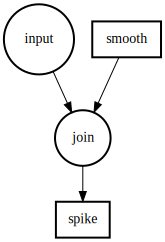

In [18]:
# print(pipeline.make_dot(with_style=False))
demo_util.display_dot(dot_data=pipeline.make_dot())

## Run computational pipeline job

In [19]:
from datetime import datetime, timezone

In [20]:
pipeline_job = op.PipelineJob(
    pipeline=pipeline,
    input_packet={
        "traces": [
            op.PathSet.COLLECTION(
                blobs=[
                    op.Blob(
                        kind=op.BlobKind.FILE,
                        location=op.Uri(
                            namespace="default",
                            path=f"{data_dir}/subjects/{i}.csv",
                        ),
                        checksum="",
                    )
                ]
            )
            for i in range(1, NUM_FILES + 1)
        ],
        "configs": [
            op.PathSet.COLLECTION(
                blobs=[
                    op.Blob(
                        kind=op.BlobKind.FILE,
                        location=op.Uri(
                            namespace="default",
                            path=f"{data_dir}/configs/{i}.json",
                        ),
                        checksum="",
                    )
                ]
            )
            for i in (1, 2)
        ],
    },
    output_dir=op.Uri(namespace="default", path=f"{data_dir}/spike_pipeline"),
    namespace_lookup=namespace_lookup,
)

In [21]:
# pipeline_job.input_packet()
pipeline_job.input_packet()["traces"][0].blobs[0].checksum

'c5c66f4cddd21e75fbe03244af721b23345de4bbfd2466f4498e4c9f17b00c48'

In [22]:
pipeline_run = await client.start_pipeline_job(pipeline_job=pipeline_job)

In [23]:
{
    "created": pipeline_run.created(),
    "status": pipeline_run.status(),
    "terminated": pipeline_run.terminated(),
}

{'created': 1762225302,
 'status': <PipelineStatus.RUNNING: 2>,
 'terminated': None}

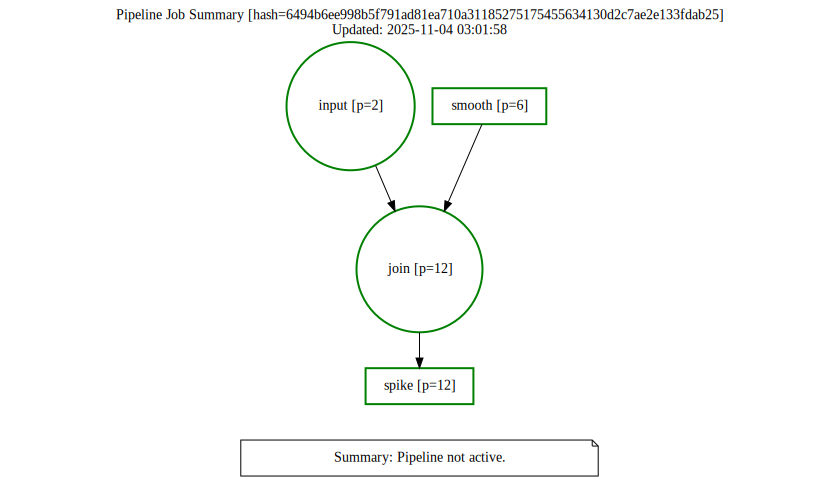

In [24]:
demo_util.animate_display(
    next_display_object=lambda: (
        demo_util.display_dot(dot_data=pipeline_run.summarize_dot())
        if not pipeline_run.terminated()
        or datetime.now(timezone.utc).timestamp() <= pipeline_run.terminated() + 2
        else None
    )
)

In [25]:
pipeline_result = await client.get_pipeline_result(pipeline_run=pipeline_run)

In [26]:
{
    "created": pipeline_result.created,
    "status": pipeline_result.status,
    "terminated": pipeline_result.terminated,
}

{'created': 1762225302,
 'status': <PipelineStatus.COMPLETED: 0>,
 'terminated': 1762225317}

In [27]:
# print(pipeline_run.summarize_dot())

## Roadmap

- Educational / Pitching Content
- Simpler, python-friendly experience
- Pipeline of pipelines
- Kubernetes orchestrator
- Queries and data exploration
- Dashboard GUIs
- Multi-agent support
- Tags
- Memoization
- Filter operator
- Agent resource limits
- Support external extensibility

## Teardown

In [28]:
import shutil
from pathlib import Path

In [29]:
shutil.rmtree(Path(namespace_lookup["default"]) / store_dir)
shutil.rmtree(Path(namespace_lookup["default"]) / data_dir)

In [30]:
# restart kernel between notebooks to shutdown active agent